Date: 2016-01-25

In [26]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%reload_ext snakeviz

from collections import namedtuple
from functools import partial, wraps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact
from mpl_toolkits.axes_grid1 import make_axes_locatable

from src.data_processing import (get_interpolated_position_dataframe,
                                 get_mark_indicator_dataframe,
                                 make_tetrode_dataframe, reshape_to_segments)
from src.ripple_detection import get_epoch_ripples
from src.ripple_decoding import (combined_likelihood,
                                 estimate_marked_encoding_model, get_ripple_info,
                                 joint_mark_intensity, poisson_mark_likelihood,
                                 predict_state, _compute_decision_state_probability,
                                 _get_bin_centers, estimate_state_transition,
                                 set_initial_conditions, evaluate_mark_space)

In [2]:
Animal = namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

In [3]:
epoch_index = ('HPa', 8, 2)
print('\nDecoding ripples for Animal {0}, Day {1}, Epoch #{2}:'.format(
    *epoch_index))


Decoding ripples for Animal HPa, Day 8, Epoch #2:


In [4]:
n_place_bins = 61
place_std_deviation = None

## Encoding

In [5]:
def _convert_to_states(function):
    @wraps(function)
    def wrapper(*args, **kwargs):
        d = function(*args, **kwargs)
        return [d['Outbound'], d['Outbound'],
                d['Inbound'], d['Inbound']]
    return wrapper


@_convert_to_states
def _get_place(position_info):
    return {trajectory_direction: grouped.loc[:, 'linear_distance'].values
            for trajectory_direction, grouped
            in (position_info
                .groupby('trajectory_direction'))}


@_convert_to_states
def _get_place_at_spike(mark_tetrode_data, position_info):
    return {trajectory_direction: grouped.dropna().linear_distance.values
            for trajectory_direction, grouped
            in (mark_tetrode_data
                .join(position_info)
                .groupby('trajectory_direction'))}


@_convert_to_states
def _get_training_marks(mark_tetrode_data, position_info, mark_variables):
    return {trajectory_direction: (grouped.dropna()
                                   .loc[:, mark_variables].values)
            for trajectory_direction, grouped
            in (mark_tetrode_data
                .join(position_info)
                .groupby('trajectory_direction'))}

In [6]:
tetrode_info = make_tetrode_dataframe(animals)[
    epoch_index]

tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    (tetrode_info.descrip != 'CA1Ref'), :]

area  depth descrip  numcells animal  \
animal day epoch_ind tetrode_number                                         
HPa    8   2         1                CA1    113  riptet        12    HPa   
                     2                CA1    121     NaN         0    HPa   
                     4                CA1    116  riptet        15    HPa   
                     5                CA1    116  riptet         0    HPa   
                     6                CA1    110  riptet         0    HPa   
                     7                CA1    114  riptet         0    HPa   
                     8               iCA1    114  riptet         0    HPa   
                     9               iCA1    100  riptet         0    HPa   
                     10              iCA1     96     NaN         0    HPa   
                     11              iCA1    106  riptet         0    HPa   
                     12              iCA1    114  riptet         3    HPa   
                     13              iCA1    120     NaN         0    HPa   
                     14              iCA1    105  riptet         6    HPa   

                                     day  epoch_ind  tetrode_number tetrode_id  
animal day epoch_ind tetrode_number                                             
HPa    8   2         1                 8          2               1     HPa821  
                     2                 8          2               2     HPa822  
                     4                 8          2               4     HPa824  
                     5                 8          2               5     HPa825  
                     6                 8          2               6     HPa826  
                     7                 8          2               7     HPa827  
                     8                 8          2               8     HPa828  
                     9                 8          2               9     HPa829  
                     10                8          2              10    HPa8210  
                     11                8          2              11    HPa8211  
                     12                8          2              12    HPa8212  
                     13                8          2              13    HPa8213  
                     14                8          2              14    HPa8214

In [7]:
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
tetrode_marks = [(get_mark_indicator_dataframe(tetrode_index, animals)
                  .loc[:, mark_variables])
                 for tetrode_index in tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1']) &
    (tetrode_info.descrip != 'CA1Ref'), :].index]

position_variables = ['linear_distance', 'trajectory_direction',
                      'speed']
position_info = (get_interpolated_position_dataframe(
    epoch_index, animals).loc[:, position_variables])

In [8]:
train_position_info = position_info.query('speed > 4')

place = _get_place(train_position_info)
place_at_spike = [_get_place_at_spike(mark_tetrode_data,
                                      train_position_info)
                  for mark_tetrode_data in tetrode_marks]
training_marks = [_get_training_marks(mark_tetrode_data,
                                      train_position_info,
                                      mark_variables)
                  for mark_tetrode_data in tetrode_marks]

place_bin_edges = np.linspace(
    np.floor(position_info.linear_distance.min()),
    np.ceil(position_info.linear_distance.max()),
    n_place_bins + 1)
place_bin_centers = _get_bin_centers(place_bin_edges)

if place_std_deviation is None:
    place_std_deviation = place_bin_edges[1] - place_bin_edges[0]

(place_occupancy, ground_process_intensity, place_field_estimator,
 training_marks) = estimate_marked_encoding_model(
    place_bin_centers, place, place_at_spike, training_marks,
    place_std_deviation=place_std_deviation)

mark_std_deviation = 20

fixed_joint_mark_intensity = partial(
    joint_mark_intensity, place_field_estimator=place_field_estimator,
    place_occupancy=place_occupancy, training_marks=training_marks,
    mark_std_deviation=mark_std_deviation)

combined_likelihood_kwargs = dict(
    likelihood_function=poisson_mark_likelihood,
    likelihood_kwargs=dict(
        joint_mark_intensity=fixed_joint_mark_intensity,
        ground_process_intensity=ground_process_intensity)
)

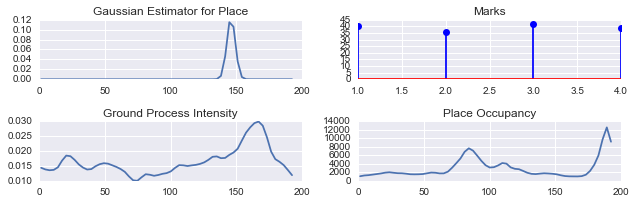

In [9]:
mark_ind = 2000
tetrode_ind = 0

n_marks = training_marks[tetrode_ind].shape[1]

fig, ax = plt.subplots(2, 2, figsize=(9, 3))
ax[0, 0].plot(place_bin_centers, place_field_estimator[tetrode_ind][:n_place_bins, mark_ind]);
ax[0, 0].set_title('Gaussian Estimator for Place');

ax[0, 1].stem(np.arange(1,n_marks+1), training_marks[tetrode_ind][mark_ind, :]);
ax[0, 1].set_title('Marks');

ax[1, 0].plot(place_bin_centers, ground_process_intensity[tetrode_ind][:n_place_bins]);
ax[1, 0].set_title('Ground Process Intensity');

ax[1, 1].plot(place_bin_centers, place_occupancy[:n_place_bins]);
ax[1, 1].set_title('Place Occupancy');
plt.tight_layout()

In [10]:
signal_ind = -1
n_mark_bins = 8
n_states = 4
n_parameters = place_occupancy.shape[0]
state_index = (np.ones((place_bin_centers.shape[0], n_states)) * np.arange(0, n_states)).T.flatten()

# mark_min = np.floor(min([tetrode_marks.min() for tetrode_marks in training_marks]))
# mark_max = np.ceil(max([tetrode_marks.max() for tetrode_marks in training_marks]))
# mark_min, mark_max = -50, 300
# mark_bin_edges = np.linspace(mark_min, mark_max, n_mark_bins)
# mark_grid1, mark_grid2, mark_grid3, mark_grid4 = np.meshgrid(
#     mark_bin_edges, mark_bin_edges, mark_bin_edges, mark_bin_edges)

# cur_joint_mark = np.zeros((n_mark_bins, n_mark_bins, n_mark_bins, n_mark_bins, n_parameters))
# test_mark = np.nditer([mark_grid1, mark_grid2, mark_grid3, mark_grid4], flags=['multi_index'])
# n_iter = mark_grid1.flatten().shape[0]
# with tqdm(total=n_iter) as progress_bar:
#     while not test_mark.finished:
#         cur_joint_mark[test_mark.multi_index] = np.dot(place_field_estimator[signal_ind],
#                             evaluate_mark_space(
#                     np.asarray(test_mark.value),
#                     training_marks=training_marks[signal_ind],
#                     mark_std_deviation=mark_std_deviation)) / place_occupancy
#         progress_bar.update()
#         test_mark.iternext()

In [11]:
# fig, axes = plt.subplots(n_marks, n_states, figsize=(12,9))
# mark_bin_grid, place_bin_grid = np.meshgrid(mark_bin_edges, place_bin_centers)
# marks_ind = set(range(n_marks))
state_names = ['outbound_forward', 'outbound_reverse',
               'inbound_forward', 'inbound_reverse']

# for cur_state in np.unique(state_index).astype(int):
#     for cur_mark in range(n_marks):
#         other_mark_axes = tuple(marks_ind - {cur_mark})
#         mesh = axes[cur_mark, cur_state].pcolormesh(place_bin_grid, mark_bin_grid,
#                               cur_joint_mark.sum(axis=other_mark_axes)[:, state_index==cur_state].T,
#                               cmap='viridis', vmin=0, vmax=cur_joint_mark.max()+1E-9);
#         axes[cur_mark, cur_state].set_title(
#             '{state},\nmark #{mark}'.format(
#                 state=state_names[cur_state], mark=cur_mark+1))

# plt.tight_layout()
# plt.colorbar(mesh)

## State Transition

In [12]:
state_transition = estimate_state_transition(
    train_position_info, place_bin_edges)

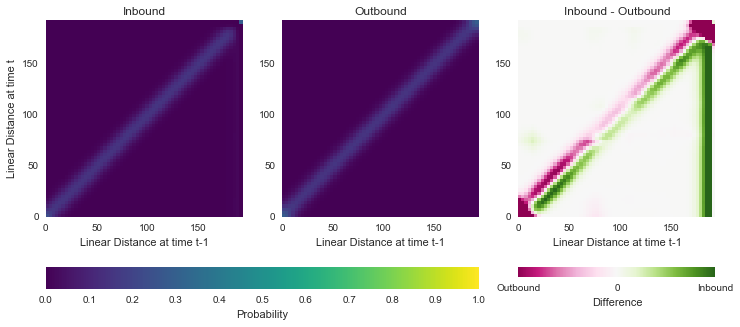

In [13]:
def plot_state_transition(state_transition, grid, ax=None,
                          vmin=0, vmax=1, cmap='viridis'):
    if ax is None:
        ax = plt.gca()
    x_grid, y_grid = np.meshgrid(grid, grid)
    mesh = ax.pcolormesh(x_grid, y_grid, state_transition,
                         cmap=cmap, vmin=vmin, vmax=vmax)
    grid_extent = (grid.min(), grid.max())
    ax.set_xlim(grid_extent)
    ax.set_ylim(grid_extent)
    ax.set_aspect('equal')
    return mesh
    
fig, ax = plt.subplots(1, 3, figsize=(12,6))

outbound_state_transitions = state_transition[:n_place_bins, :n_place_bins]
inbound_state_transitions = state_transition[n_place_bins+1:2*(n_place_bins)+1,
                                             n_place_bins+1:2*(n_place_bins)+1]


plot_state_transition(inbound_state_transitions, place_bin_edges, ax=ax[0])
ax[0].set_xlabel('Linear Distance at time t-1')
ax[0].set_ylabel('Linear Distance at time t')
ax[0].set_title('Inbound')

mesh1 = plot_state_transition(outbound_state_transitions, place_bin_edges, ax=ax[1])
ax[1].set_title('Outbound')
ax[1].set_xlabel('Linear Distance at time t-1')

state_transition_difference = inbound_state_transitions - outbound_state_transitions
mesh2 = plot_state_transition(state_transition_difference, place_bin_edges, ax=ax[2],
                              vmin=-0.01, vmax=0.01, cmap='PiYG')
ax[2].set_title('Inbound - Outbound')
ax[2].set_xlabel('Linear Distance at time t-1')

fig.colorbar(mesh1, ax=ax.ravel().tolist()[:2], label='Probability', orientation='horizontal')
cbar = fig.colorbar(mesh2, ax=ax[2], label='Difference', orientation='horizontal', ticks=[-0.01, 0, 0.01])
cbar.ax.set_xticklabels(['Outbound', '0', 'Inbound']);

## Initial Conditions

In [14]:
# Initial Conditions
n_states = len(state_names)
initial_conditions = set_initial_conditions(
    place_bin_edges, place_bin_centers, n_states)

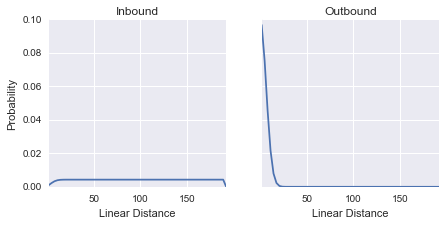

In [15]:
outbound_initial_conditions = initial_conditions[:n_place_bins]
inbound_initial_conditions = initial_conditions[n_place_bins+1:2*(n_place_bins)+1]

fig, ax = plt.subplots(1, 2, figsize=(7, 3), sharex=True, sharey=True)
ax[0].plot(place_bin_centers, inbound_initial_conditions)
ax[0].set_ylabel('Probability')
ax[0].set_xlabel('Linear Distance')
ax[0].set_title('Inbound')
ax[0].set_xlim((place_bin_centers.min(), place_bin_centers.max()))
ax[1].plot(place_bin_centers, outbound_initial_conditions)
ax[1].set_xlabel('Linear Distance')
ax[1].set_title('Outbound')
ax[1].set_xlim((place_bin_centers.min(), place_bin_centers.max()));

## Decode

In [16]:
def _get_ripple_marks(tetrode_marks, ripple_times, sampling_frequency):
    mark_ripples = [reshape_to_segments(
    mark_tetrode_data, ripple_times,
    concat_axis=0, sampling_frequency=sampling_frequency)
    for mark_tetrode_data in tetrode_marks]

    return [np.stack([df.loc[ripple_ind+1, :].values
                       for df in mark_ripples], axis=1)
            for ripple_ind in np.arange(len(ripple_times))]

In [17]:
decoder_kwargs = dict(
    initial_conditions=initial_conditions,
    state_transition=state_transition,
    likelihood_function=combined_likelihood,
    likelihood_kwargs=combined_likelihood_kwargs
)

In [18]:
sampling_frequency = 1500
ripple_times = get_epoch_ripples(
    epoch_index, animals, sampling_frequency=sampling_frequency)
test_marks = _get_ripple_marks(
    tetrode_marks, ripple_times, sampling_frequency)


Detecting ripples for Animal HPa, Day 8, Epoch #2...



In [22]:
%%snakeviz
posterior_density = [predict_state(ripple_marks, **decoder_kwargs)
                     for ripple_marks in tqdm(test_marks)]

/Users/edeno/Documents/GitHub/Jadhav-2016-Data-Analysis/src/ripple_decoding.py:85: RuntimeWarning: invalid value encountered in true_divide
  return distribution / distribution.sum()


 
*** Profile stats marshalled to file '/var/folders/rt/nhwr2l2937n0f8g854zq3s6w0000gn/T/tmp5x3jejij'. 


In [23]:
n_states = len(state_names)
n_ripples = len(ripple_times)
decision_state_probability = [
    _compute_decision_state_probability(density, n_states)
    for density in posterior_density]

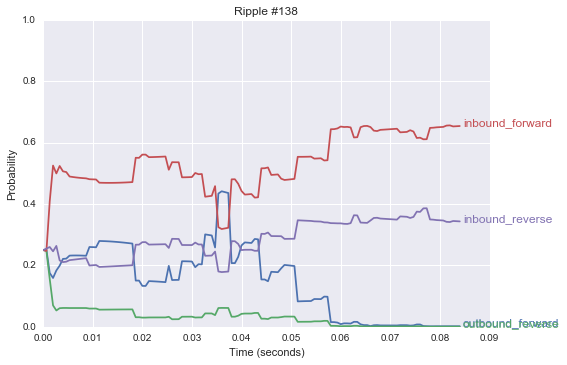

In [24]:
def browse_ripple_fits(decision_state_probability, state_names, sampling_frequency=1500):
    def plot_fits(ripple_ind):
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        lineObjects = plt.plot(time, decision_state_probability[ripple_ind])
        # plt.legend(lineObjects, discrete_state_names)
        for state_ind, state_name in enumerate(state_names):
                plt.text(time[-1] + (1 / sampling_frequency),
                         decision_state_probability[ripple_ind][-1, state_ind],
                         state_name,
                         color=lineObjects[state_ind].get_color())
        plt.ylim((0, 1))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Probability')
        plt.title('Ripple #{ripple_number}'.format(ripple_number=ripple_ind+1))
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_fits(decision_state_probability, state_names)

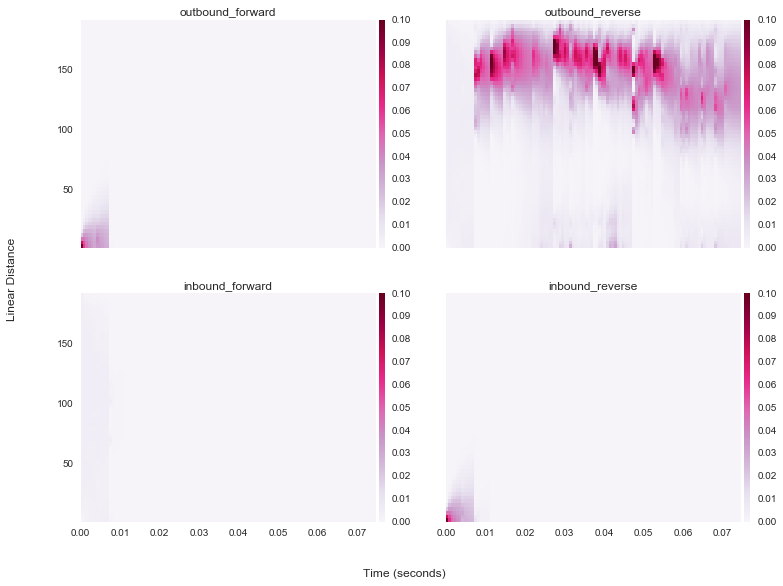

In [25]:
def browse_ripple_densities(posterior_density, state_names,
                            place_bin_centers,
                            sampling_frequency=1500):    
    def plot_fits(ripple_ind):
        fig, axes = plt.subplots(2, 2, figsize=(12,9), sharex=True, sharey=True)
        time_length = decision_state_probability[ripple_ind].shape[0]
        time = np.arange(time_length) / sampling_frequency
        n_time = posterior_density[ripple_ind].shape[0]
        n_states = len(state_names)
        new_shape = (n_time, n_states, -1)
        cur_density = np.reshape(posterior_density[ripple_ind], new_shape)
        [time_grid, place_bins] = np.meshgrid(time, place_bin_centers)
        for state_ind, ax in enumerate(axes.flatten()):
            try:
                mesh = ax.pcolormesh(time_grid, place_bins, cur_density[:, state_ind, :].squeeze().T,
                                     cmap='PuRd', vmin=0, vmax=.1)
                ax.set_xlim((time.min(), time.max()))
                ax.set_ylim((place_bin_centers.min(), place_bin_centers.max()))
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="2%", pad=0.05)
                plt.colorbar(mesh, cax=cax)
                ax.set_title(state_names[state_ind])
            except ValueError:
                pass
        fig.text(0.5, 0.04, 'Time (seconds)', ha='center')
        fig.text(0.04, 0.5, 'Linear Distance', va='center', rotation='vertical')
        
    interact(plot_fits, ripple_ind=(0, len(decision_state_probability)-1), continuous_update=False)
        
browse_ripple_densities(posterior_density, state_names,
                        place_bin_centers)